In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:80% !important;}
div.prompt {min-width:70px;}
div#toc-header{margin-top:150px;}
span.toc-item-num{display:none;}
div.CodeMirror {font-family:Consolas}
div.input {font-family:Consolas}
</style>
"""))

# CNN 준비 import / GPU 메모리 정리

In [2]:
import pandas as pd 
import numpy as np
import os
import torch
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, AvgPool2D, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tqdm import tqdm  # 진행률 표시

In [3]:
# GPU 메모리를 점진적으로 할당하도록 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
torch.cuda.empty_cache()  # GPU 메모리 정리

In [ ]:
# warining 경고 안보이게
warnings.filterwarnings(action='ignore')
# warining 경고 보이게
# warnings.filterwarnings(action='default')

## 이미지, csv 불러오기 

In [ ]:
filepath = ('../team_project/data/')

In [5]:
# 데이터 불러오기
X = np.load(filepath,'data.npy')  # 이미지 데이터 (예: 80,000개)
y_df = pd.read_csv(filepath,'painting.csv')  # CSV 레이블 데이터

In [6]:
# y 라벨 인코딩 (문자형 → 숫자로 변환)
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y_df["genre"])  # 장르를 숫자로 변환

# y 원핫 인코딩 
onehot_encoder = OneHotEncoder(sparse=False)
y_onehot = onehot_encoder.fit_transform(y_labels.reshape(-1, 1))
y_labels[:5],  y_onehot[:5]

C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(array([20, 33, 30, 14, 22]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        

In [7]:
# 장르별 데이터 개수 확인
genre_counts = y_df["genre"].value_counts()
genre_ratios = genre_counts / genre_counts.sum()  # 장르별 비율 유지
genre_counts.head(), genre_ratios.head()

(portrait              14294
 landscape             13478
 genre painting        11089
 religious painting     6694
 abstract               5264
 Name: genre, dtype: int64,
 portrait              0.178323
 landscape             0.168143
 genre painting        0.138339
 religious painting    0.083510
 abstract              0.065670
 Name: genre, dtype: float64)

In [8]:
# 각 장르에서 샘플링할 개수 설정
total_samples = 40000  # 사용할 총 샘플 수
samples_per_genre = (genre_ratios * total_samples).astype(int)

# 최소 10개 이상 유지
min_samples_per_class = 10
samples_per_genre[samples_per_genre < min_samples_per_class] = min_samples_per_class

In [9]:
# 샘플링 수행 (각 장르에서 비율 유지)
selected_indices = []

for genre, sample_count in samples_per_genre.items():
    genre_indices = y_df[y_df["genre"] == genre].index.tolist()
    sampled_indices = np.random.choice(genre_indices, sample_count)
    selected_indices.extend(sampled_indices)

X_sample = X[selected_indices]  # 이미지 데이터 샘플링
y_sample = y_onehot[selected_indices]  # 레이블 샘플링

X_sample.shape, y_sample.shape

((40009, 128, 128, 3), (40009, 44))

In [10]:
# train-test 데이터 분할 (stratify=y_sample으로 클래스 균형 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.3, stratify=y_sample, shuffle=True)

X_train.shape, y_train.shape

((28006, 128, 128, 3), (28006, 44))

In [11]:
# 학습 데이터 증강 설정
train_datagen = ImageDataGenerator(
    rotation_range=20,  # 0~20도 회전
    width_shift_range=0.1,  # 가로 이동 (최대 10%)
    height_shift_range=0.1,  # 세로 이동 (최대 10%)
    shear_range=0.2,  # 전단 변형
    zoom_range=0.2,  # 확대/축소 (20%)
    horizontal_flip=True,  # 좌우 반전
    fill_mode="nearest"  # 빈 픽셀을 가장 가까운 값으로 채움
)

# 증강된 학습 데이터 생성
train_generator = train_datagen.flow(X_train, y_train, batch_size=64)

# 검증 데이터는 증강 없이 사용
valid_datagen = ImageDataGenerator()
valid_generator = valid_datagen.flow(X_test, y_test, batch_size=64)

## CustomHistory class

In [12]:
class CustomHistory(Callback):  # on_epoch_end()는 각 에포크 종료시 자동 호출
    def __init__(self, times=5):  # 생성자 함수
        self.epoch = 0
        self.times = times
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if self.epoch%self.times == 0:
            print('epoch:{}, loss:{}, acc:{}, val_loss:{}, val_acc:{}'.format(self.epoch, logs.get('loss'), logs.get('accuracy'), logs.get('val_loss'), logs.get('val_accuracy')))

## 1.LeNet

In [29]:
class LeNet:
    @staticmethod
    def build(input_shape=(128, 128, 3), num_classes=len(y_train[0]), activation='relu'):
        model = Sequential([
            Input(shape=input_shape),

            Conv2D(32, kernel_size=(5, 5), activation=activation, kernel_initializer=GlorotNormal(), padding='same'), # GlorotNormal() 가중치 초기화 
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),

            Conv2D(64, kernel_size=(5, 5), activation=activation, kernel_initializer=GlorotNormal(), padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),

            Conv2D(128, kernel_size=(3, 3), activation=activation, kernel_initializer=GlorotNormal(), padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),

            Flatten(), # 평탄화

            Dense(256, activation=activation, kernel_initializer=GlorotNormal()),
            BatchNormalization(),
            Dropout(0.4),

            Dense(128, activation=activation, kernel_initializer=GlorotNormal()),
            BatchNormalization(),
            Dropout(0.4),

            Dense(num_classes, activation='softmax')  # 최종 출력층
        ])
        return model

In [30]:
model = LeNet.build(input_shape=(128, 128, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                        

In [31]:
# 학습설정
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy',
              metrics=['accuracy'])
# 학습시키기
customHistory = CustomHistory(3)
earlystopping = EarlyStopping(patience=30)
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[customHistory,
                                                                                             earlystopping], verbose=1)

Epoch 1/100
876/876 [==============================] - 47s 40ms/step - loss: 2.9727 - accuracy: 0.2926 - val_loss: 2.3708 - val_accuracy: 0.3599
Epoch 2/100
876/876 [==============================] - 32s 36ms/step - loss: 2.3280 - accuracy: 0.3677 - val_loss: 2.5180 - val_accuracy: 0.3079
Epoch 3/100
876/876 [==============================] - 32s 37ms/step - loss: 2.1323 - accuracy: 0.4012 - val_loss: 2.2982 - val_accuracy: 0.3641
Epoch 4/100
876/876 [==============================] - 33s 38ms/step - loss: 1.9998 - accuracy: 0.4301 - val_loss: 2.0619 - val_accuracy: 0.4112
Epoch 5/100
876/876 [==============================] - 33s 38ms/step - loss: 1.8512 - accuracy: 0.4764 - val_loss: 2.1312 - val_accuracy: 0.3962
Epoch 6/100
876/876 [==============================] - 33s 38ms/step - loss: 1.7144 - accuracy: 0.5097 - val_loss: 1.9924 - val_accuracy: 0.4381
Epoch 7/100
876/876 [==============================] - 33s 38ms/step - loss: 1.4862 - accuracy: 0.5736 - val_loss: 2.0146 - val_ac

In [32]:
# 모델평가
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}%'.format(accuracy*100))

376/376 [==============================] - 4s 11ms/step - loss: 2.9472 - accuracy: 0.5665
accuracy : 56.65%


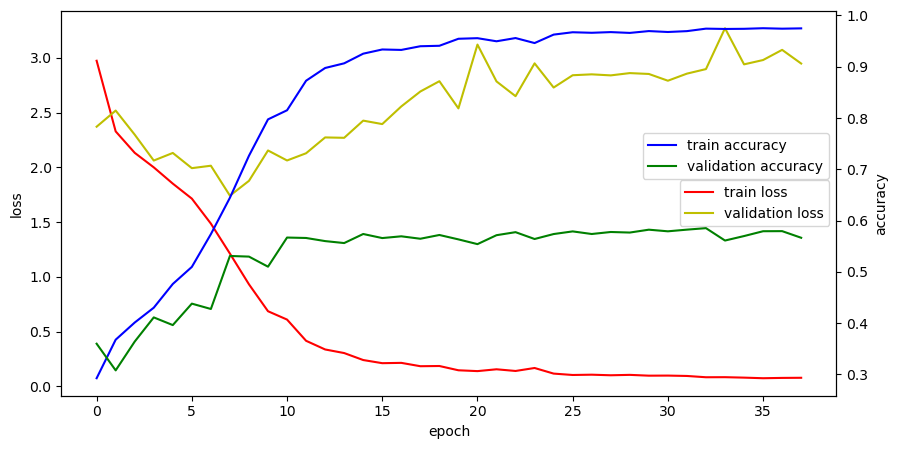

In [33]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [34]:
model.save("../team_project/data/cnn_lenet_model.h5")
print("모델 저장 완료")

모델 저장 완료


## 2.AlexNet

In [12]:
class AlexNet:
    @staticmethod
    def build(input_shape=(128,128,3), activation='relu', num_classes=len(y_train[0])):  
        model = Sequential([
            Input(shape=input_shape),

            Conv2D(32, kernel_size=(5,5), strides=(2,2), activation=activation, padding='same'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),
            BatchNormalization(),

            Conv2D(64, kernel_size=(3,3), activation=activation, padding='same'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),
            BatchNormalization(),

            Conv2D(128, kernel_size=(3,3), activation=activation, padding='same'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),

            Flatten(),

            Dense(512, activation=activation),
            Dropout(0.3),
            Dense(512, activation=activation),
            Dropout(0.3),

            Dense(num_classes, activation='softmax')
        ])
        return model

In [13]:
model = AlexNet.build(input_shape=(128, 128, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                        

In [14]:
# 학습설정
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy',
              metrics=['accuracy'])
# 학습시키기
customHistory = CustomHistory(3)
earlystopping = EarlyStopping(patience=30)
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[customHistory,
                                                                                             earlystopping], verbose=1)

Epoch 1/100
876/876 [==============================] - 26s 13ms/step - loss: 2.5336 - accuracy: 0.2935 - val_loss: 2.2531 - val_accuracy: 0.3607
Epoch 2/100
876/876 [==============================] - 10s 11ms/step - loss: 2.2683 - accuracy: 0.3661 - val_loss: 2.1850 - val_accuracy: 0.3899
Epoch 3/100
876/876 [==============================] - 10s 11ms/step - loss: 2.1097 - accuracy: 0.4057 - val_loss: 2.1500 - val_accuracy: 0.3998
Epoch 4/100
876/876 [==============================] - 9s 11ms/step - loss: 1.9777 - accuracy: 0.4380 - val_loss: 2.0347 - val_accuracy: 0.4268
Epoch 5/100
876/876 [==============================] - 10s 11ms/step - loss: 1.8385 - accuracy: 0.4731 - val_loss: 1.9445 - val_accuracy: 0.4545
Epoch 6/100
876/876 [==============================] - 10s 11ms/step - loss: 1.6713 - accuracy: 0.5145 - val_loss: 1.8614 - val_accuracy: 0.4731
Epoch 7/100
876/876 [==============================] - 10s 11ms/step - loss: 1.5028 - accuracy: 0.5651 - val_loss: 1.8311 - val_acc

In [15]:
# 모델평가
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}%'.format(accuracy*100))

376/376 [==============================] - 2s 4ms/step - loss: 2.5418 - accuracy: 0.5919
accuracy : 59.19%


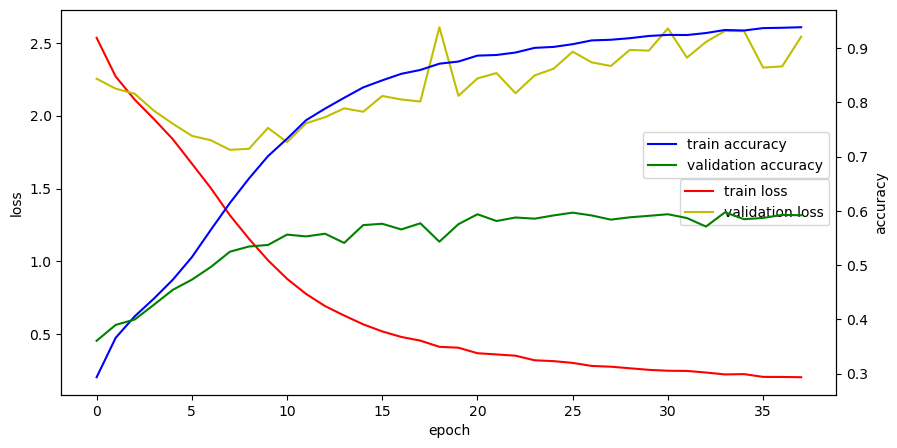

In [16]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [17]:
model.save("../team_project/data/cnn_alexnet_model.h5")
print("모델 저장 완료")

모델 저장 완료


## 3. VGGNet (VGG16)

In [13]:
# Feature Extractor로 사용할 VGG16 모델 불러오기 (Fully Connected Layer 제외)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# 기존 모델의 가중치를 고정 (Feature Extractor 역할)
for layer in base_model.layers:
    layer.trainable = False  # 기존 가중치 고정

# 새로운 Fully Connected Layer 추가
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(y_train[0]), activation='softmax')(x)  # 클래스 개수에 맞게 변경

# 최종 모델 생성
model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [15]:
# 학습설정
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
# 학습시키기
customHistory = CustomHistory(3)
earlystopping = EarlyStopping(patience=30,restore_best_weights=True)
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[customHistory,
                                                                                             earlystopping], verbose=1)

Epoch 1/100
876/876 [==============================] - 75s 77ms/step - loss: 3.8824 - accuracy: 0.2854 - val_loss: 2.3313 - val_accuracy: 0.4155
Epoch 2/100
876/876 [==============================] - 66s 75ms/step - loss: 2.5411 - accuracy: 0.3406 - val_loss: 2.1951 - val_accuracy: 0.4243
Epoch 3/100
876/876 [==============================] - 66s 75ms/step - loss: 2.3464 - accuracy: 0.3713 - val_loss: 2.0669 - val_accuracy: 0.4451
Epoch 4/100
876/876 [==============================] - 66s 75ms/step - loss: 2.2118 - accuracy: 0.4072 - val_loss: 2.0448 - val_accuracy: 0.4661
Epoch 5/100
876/876 [==============================] - 66s 75ms/step - loss: 2.1478 - accuracy: 0.4246 - val_loss: 1.9921 - val_accuracy: 0.4639
Epoch 6/100
876/876 [==============================] - 66s 75ms/step - loss: 2.0685 - accuracy: 0.4416 - val_loss: 1.9285 - val_accuracy: 0.4751
Epoch 7/100
876/876 [==============================] - 66s 75ms/step - loss: 2.0154 - accuracy: 0.4580 - val_loss: 1.9233 - val_ac

Epoch 40/100
876/876 [==============================] - 66s 75ms/step - loss: 1.4691 - accuracy: 0.5926 - val_loss: 1.9419 - val_accuracy: 0.5429
Epoch 41/100
876/876 [==============================] - 65s 74ms/step - loss: 1.4564 - accuracy: 0.5928 - val_loss: 1.9240 - val_accuracy: 0.5499
Epoch 42/100
876/876 [==============================] - 64s 73ms/step - loss: 1.4358 - accuracy: 0.5958 - val_loss: 1.9413 - val_accuracy: 0.5486
Epoch 43/100
876/876 [==============================] - 64s 73ms/step - loss: 1.4334 - accuracy: 0.5952 - val_loss: 1.9671 - val_accuracy: 0.5531
Epoch 44/100
876/876 [==============================] - 64s 73ms/step - loss: 1.4337 - accuracy: 0.5949 - val_loss: 2.0039 - val_accuracy: 0.5494
Epoch 45/100
876/876 [==============================] - 64s 73ms/step - loss: 1.4338 - accuracy: 0.5982 - val_loss: 1.9817 - val_accuracy: 0.5549
Epoch 46/100
876/876 [==============================] - 64s 73ms/step - loss: 1.4304 - accuracy: 0.5967 - val_loss: 2.0029 -

In [16]:
# 모델평가
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}%'.format(accuracy*100))

376/376 [==============================] - 19s 51ms/step - loss: 1.7681 - accuracy: 0.5425
accuracy : 54.25%


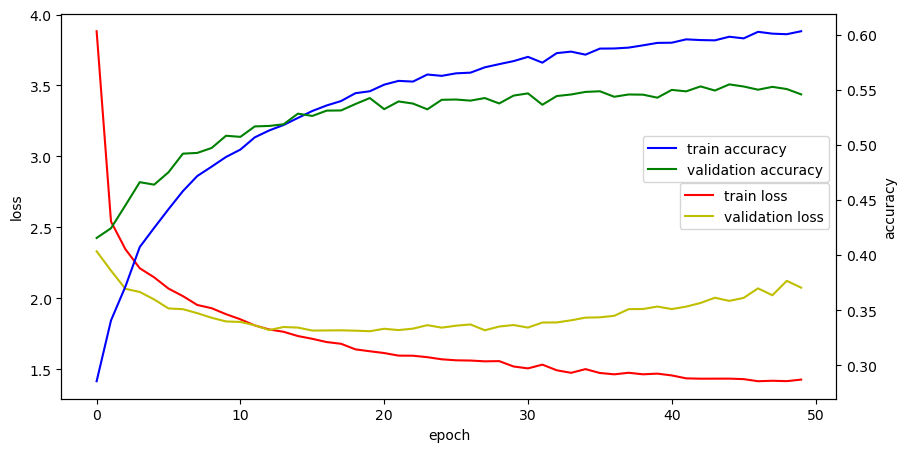

In [17]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [19]:
model.save("../team_project/data/cnn_vgg16_model.h5")
print("모델 저장 완료")

모델 저장 완료


# Machine Learning 작업을 위한 특징 벡터 추출

In [4]:
filepath=r'..\team_project\data'

In [5]:
painting_lst = np.load(os.path.join(filepath,'data.npy'))
painting_lst.shape

(80158, 128, 128, 3)

In [6]:
# VGG16 모델 로드 
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
model = Model(inputs=base_model.input, outputs=tf.keras.layers.GlobalAveragePooling2D()(base_model.output))

def extract_features_batch(image_batch):
    """이미지 배치를 받아 특징 벡터 추출"""
    image_batch = preprocess_input(image_batch)  # EfficientNet 전처리 적용
    features = model.predict(image_batch, verbose=0)  # 특징 벡터 추출
    return features  # shape: (batch_size, 1280)

# 데이터셋 로드 (메모리 절약을 위해 float32 변환)
painting_lst = np.array(painting_lst, dtype=np.float32)  # float64 → float32 변환
num_samples = painting_lst.shape[0]

# 배치 단위로 특징 벡터 추출
batch_size = 128  # 메모리 부담을 줄이기 위해 조정
feature_list = []

for i in tqdm(range(0, num_samples, batch_size), desc="Extracting Features"):
    batch = painting_lst[i:i+batch_size]  # 배치 단위로 데이터 가져오기
    features = extract_features_batch(batch)  # 특징 벡터 추출
    feature_list.append(features)

# 모든 특징 벡터를 하나의 배열로 결합
feature_vectors = np.vstack(feature_list)  # 최종 결과 (80158, 1280)

print("Final Feature Vector Shape:", feature_vectors.shape)  # (80158, 1280)

Extracting Features: 100%|███████████████████████████████████████████████████████████| 627/627 [04:39<00:00,  2.24it/s]

Final Feature Vector Shape: (80158, 512)


In [7]:
np.save(os.path.join(filepath,'VGG_vectors.npy'),feature_vectors)